# Quantexa Task

I felt when considering scalability of the solution, there was two potential use cases in mind. One is a very large number of agents over a short time period (e.g. simulating the whole UK payment network for a day) and the other is having a more realistic payment network of fewer agents but simulating for a much longer time e.g. a year.

I elected to go for the second use case because from my understanding the task was more around the designed network structure. Simulating a short time period is extremely easy because you are unlikely to have any repeat transactions from any agent in a short time period. I also felt the second use case was more intuitive to extend into a complete solution which could handle an extremely large number of agents for a long time period. 

The task mentioned using Pyspark, I was unsure if this was mandatory. I felt my solution could be extended to handle millions of agents with billions of transactions without it and did not want to add it in just for the sake of it.

I found it easier to manage and maintain my code in a package but have created this notebook to demonstrate and explain my solution.

# Solution Overview

When considering my payment network, I thought a lot about social networks. In terms of personal accounts, people pay people they know and although the overall network is very sparse, there are also clusters of connectivity. If I pay Friend A and Friend B, it is also highly likely that Friend A also has sent payments to Friend B. Another very important concept in networks is geography and this idea really inspired me. You can have a small group of friends, in a local area you will have many groups of friends (with some rogue additional connections between the groups). This idea could be expanded further to in an area e.g. London, you have multiple local areas (with some rogue additional connections between the areas). 

This concept works well when considering businesses as well. There are local businesses such as corner shops which only local people are likely to use, there are then regional chains and of course national and international businesses. 

For this solution I have 3 concepts of size:  
- social network (group of friends)
- local network (local area)
- large network (group of local areas)

There is some code repetition between these classes which is not ideal from a software engineering perspective but I felt that it was easier to explain my abstraction and ideas in this notebook. Given more time, I would alter the code to make more generic classes that could be used to abstract from a depth here of 3 to a depth of n because the same ideas and concepts continue to apply. E.g. There is a higher degree of connectivity within England than there is between English accounts and French accounts. Similarly there are businesses that only operate in parts of the UK or the whole of England but not France or the whole of Europe but not Asia. The most important thing to consider is that these sub networks are never entirely disconnected and there are always some random connections between them. This idea has been scientifically proven by studies in the concept of being only 7 degrees of separation from anyone in the world.

## Computational Overview

Focusing more on the network of relationships is hugely advantageous from a memory and computational perspective. If we assume that the generated graph can be stored in RAM (I will discuss later how I would extend the code to get round this problem), then we can generate an infinite number of transactions in linear time and never run out of memory. All we need to do is randomly sample edges in our network and then produce a payment for that connection. The graph is directed so that people pay highly connected businesses and not the other way around.

In [1]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython


def display_python_code(filename):
    with open(f'src/{filename}') as f:
        code = f.read()

    formatter = HtmlFormatter()
    return IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
        formatter.get_style_defs('.highlight'),
        highlight(code, PythonLexer(), formatter)))

In [2]:
import networkx as nx

# Social Network

This is a network of individuals who are highly connected in both directions. This graph is built using the networkx library because it has some useful functionality

In [3]:
display_python_code("social_network.py")

In [4]:
from src.social_network import SocialSubNetwork

In [5]:
network = SocialSubNetwork()

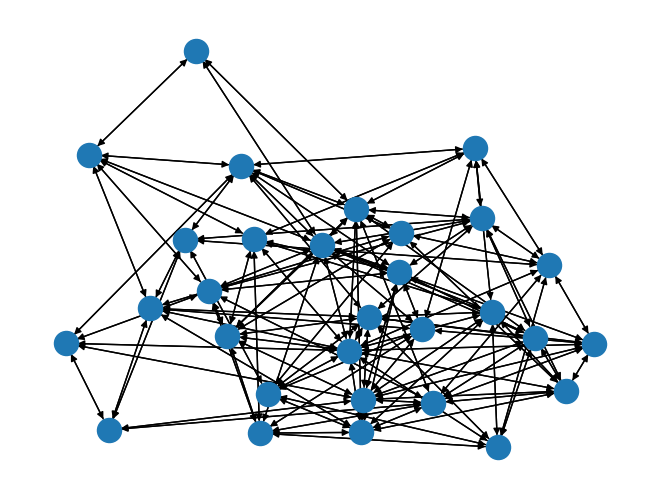

In [6]:
nx.draw(network.get_graph())

# Local Network

A local network is like a local community. Connections are far more sparse between individuals in separate social networks but they are linked by businesses in the community.

In [7]:
display_python_code("local_network.py")

We create a number of separate social networks which we then connect with some random connections. We decide the number of random connections to be proportional to the number of networks that we are joining. The default parameters here were chosen quite arbitrarily. We then add local businesses into the network. The popularity of a business is drawn from a normal distribution with values set in the config. The values are also clipped to ensure each business has a reasonable number of customers. Notice that connections to businesses only go in one direction. I guess it is possible this can sometimes be in both directions as the business may occasionally refund customers but I put this as out of scope. We keep track of the nodes which are businesses so that they are not included in the additional random transactions we add to the network at the next level of abstraction. 

In [8]:
from src.local_network import LocalNetwork

In [9]:
network = LocalNetwork(num_social_networks=3, num_local_businesses=5, num_connections_per_social_network=2, number_individuals=6)

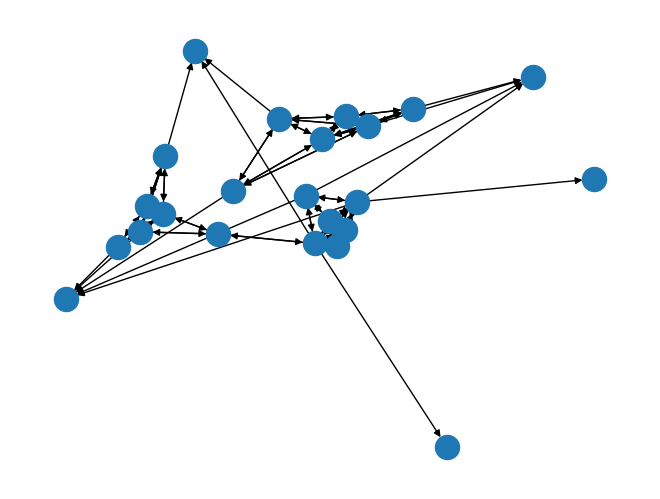

In [10]:
nx.draw(network.get_graph())

The default parameters for this step are much larger but this illustration can give a bit of intuition as to the networks structure. There are a set of loosely connected clusters with businesses around the edges.

# Large Network

 A large network is the connection of a group of communities. This could be like a county or region. The code here is relatively similar to the local network and could be abstracted to a more generic class. I can not show an illustration of the graph here because even reduced parameters can not be drawn very well within a notebook.

In [11]:
display_python_code("large_network.py")

In [12]:
from src.large_network import LargeNetwork

In [13]:
network = LargeNetwork()
network_graph = network.get_graph()

100%|███████████████████████████████████████████| 49/49 [02:14<00:00,  2.74s/it]


In [14]:
# Number of Nodes
print(len(network_graph.nodes))

85597


In [15]:
# Number of Edges
print(len(network_graph.edges))

12798525


Creating the network is quite time efficient, it slows down over time due to memory when the network gets larger.

# Generating Transactions

In [50]:
import pandas as pd
from tqdm import tqdm
import os
import random
from datetime import datetime
import numpy as np

In [20]:
# These numbers could be considerably larger
BATCH_SIZE = 100
TOTAL_BATCHES = 10

transactions_csv_path = "transactions.csv"

start_date = datetime.strptime('01/01/22 00:00:00', '%d/%m/%y %H:%M:%S')
end_date = datetime.strptime('31/12/22 00:00:00', '%d/%m/%y %H:%M:%S')


In [42]:
def rand_datetime():
    """Returns a random datetime between start and end."""

    return datetime.fromtimestamp(random.randrange(
        round(start_date.timestamp()), round(end_date.timestamp())
    ))

In [21]:
edges = list(network_graph.edges)

In [51]:
columns = ["sent", "received", "amount", "date"]

if not os.path.exists(transactions_csv_path):
    start_df = pd.DataFrame({col: [] for col in columns})
    start_df.to_csv(transactions_csv_path, index=False)

To generate transactions, all we need to do is to sample edges in the network and create a payment. For this example we just set the date to be random and the amount to be sampled from a chosen distribution. We iteratively append to a CSV file in batches.

In [58]:
for _ in tqdm(range(TOTAL_BATCHES)):
    rows = []
    
    # Simplified transaction amount to sampled from uniform distribution
    amounts = np.random.uniform(10, 100, BATCH_SIZE)
    
    # Sample a set of edges
    sampled_edges = random.sample(edges, BATCH_SIZE)
    for i, (sender, receiver) in enumerate(sampled_edges):
        rows.append([sender, receiver, round(amounts[i], 2), str(rand_datetime())])
        
    transactions = pd.DataFrame(rows, columns=columns)
    
    transactions.to_csv(transactions_csv_path, mode='a', header=False)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 419.84it/s]


In [60]:
full_df = pd.read_csv(transactions_csv_path)
full_df

,sent,received,amount,date
0,447595eb-def9-4d8c-81e8-e11011f1181a,e8c35495-ab7d-47fc-9d5d-d3812fe592f0,92.37,2022-03-15 03:53:55
1,b5af3e75-6a16-4f10-b613-2af8796ec6ac,417b99ee-2e21-4543-b827-acf0f394182f,29.13,2022-05-22 09:21:24
2,87925fe9-e800-47ae-a92d-bbe516f1b99f,e1930962-a1f0-4b08-8458-9e9e5ed0b91b,77.90,2022-05-01 16:06:19
3,56d8b4ef-19df-4dcb-b295-afd175f84710,48afafeb-df97-4d1a-92b1-5b8fb4494ab1,77.38,2022-02-09 20:28:59
4,653f4e97-8b47-4ad7-8d7a-d0a043ec93e3,9e19394c-5f31-4451-b458-97da7b3c3eb3,19.57,2022-10-14 14:16:25
...,...,...,...,...
95,a877e41f-e02f-41ea-9b63-00eccdee727e,52421231-e685-4d92-adf2-efe42331f254,48.73,2022-11-19 00:19:50
96,914a36e1-973a-405a-b040-04b9571bba8b,e8c35495-ab7d-47fc-9d5d-d3812fe592f0,44.65,2022-01-22 21:19:43
97,18191852-99d2-4584-9509-695c81a5c4df,6a502bca-9e2b-44bd-a360-2db342ccef15,92.85,2022-09-22 18:52:17
98,343060db-08d2-421c-ba2f-8d6be1f516ed,90294917-e350-4398-8a16-3891bffd2664,15.80,2022-01-23 21:05:11


In this case I am just appending to a CSV stored locally but this write procedure could easily be to a postgres table or could be saved in a series of CSVs on S3 and linked to Athena table.

# Scaling The Solution

The solution will eventually struggle to scale because of a lack of computer RAM to hold the whole networkx graph. We could partition the graph into a series of sub graphs and persist these either locally or on the cloud. We could persist the number of edges in each graph in some form of accessible store. When generating transactions, we could first sample a sub-graph and load that into memory and sample a number of transactions before moving onto the next sub graph. This method would allow us to scale to an infinite number of agents and still produce transactions in linear time. The only cost would be storage on the cloud which is relatively cheap and we could even parallelise the process of generating and persisting billions of transactions.

# Further Ideas

I wanted to use this section to illustrate some additional ideas I had of how I would improve the system if I had more time. This is in addition to the ideas I have already discussed in partitioning the graph and extending from 3 levels of locality to n levels.

- Transaction amounts: I used a very crude distribution sample for each transaction. In reality, people probably pay similar amounts to other individuals or retailers they use repeatedly. We could store the distribution for a given payment link (or even multiple distributions on a given edge).
- Transaction frequency: Another useful piece of information to store on an edge would be the relative transaction frequency, this is particularly useful when modeling businesses. Everyone has probably shopped at Amazon but there are some customers who buy their products far more often than others. This is really critical when detecting fraud, a large purchase at a retailer may look completely out of sorts for some individuals but is very normal for others,
- Recurring transactions: At the moment the system is sampled completely randomly but a lot of transactions are done on a recurring basis for the same amount e.g. for a netflix subscription or paying your landlord. This would be a good idea to add in this information
- Business transactions: In the current system, businesses only receive payments but this is overly simplified. Businesses pay other businesses for products or services as well as paying their employees.
- Generative model: as with any rules based approach, there are an infinite number of extensions that make the system less maintainable and more confusing over time. The real longer term approach would be to try and train a generative model to create realistic sub networks and connect these. It all depends on the end use case and balancing realisticness of the system vs run-time and development cost to generate it.